<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/11-training-deep-neural-networks/reusing_pretrained_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle then just reuse the lower layers of this network: this is called transfer learning. It will
not only speed up training considerably, but will also require much less training data.

For example, suppose that you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/reusing-pretrained-layers.PNG?raw=1' width='800'/>

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

Try freezing all the reused layers first (i.e., make their weights non-trainable, so gradient descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze
reused layers: this will avoid wrecking their fine-tuned weights.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freeze all remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even add more hidden layers.

## Setup

In [0]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as keras_backend

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## Transfer Learning With Keras

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [0]:
def split_dataset(X, y):
  y_5_or_6 = (y==5) | (y==6)   # sandals or shirts
  y_A = y[~y_5_or_6]
  y_A[y_A > 6] -= 2    # class indices 7, 8, 9 should be moved to 5, 6, 7
  y_B = (y[y_5_or_6] == 6).astype(np.float32)  # binary classification task: is it a shirt (class 6)?

  return ((X[~y_5_or_6], y_A), (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

X_train_B = X_train[:200]
y_train_B = y_train[:200]

In [35]:
X_train_A.shape

(43986, 28, 28)

In [36]:
X_train_B.shape

(200, 28, 28)

In [37]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [38]:
y_train_B[:30]

array([4, 0, 7, 9, 9, 9, 4, 4, 3, 4, 0, 1, 8, 6, 3, 6, 4, 3, 2, 8, 7, 3,
       4, 7, 1, 3, 4, 2, 0, 8], dtype=uint8)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [40]:
model_A = Sequential()
model_A.add(Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
  model_A.add(Dense(n_hidden, activation='selu'))
model_A.add(Dense(8, activation='softmax'))

model_A.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])

history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 6s 146us/sample - loss: 0.5909 - accuracy: 0.8099 - val_loss: 0.3772 - val_accuracy: 0.8712
Epoch 2/20
43986/43986 [==============================] - 6s 129us/sample - loss: 0.3521 - accuracy: 0.8792 - val_loss: 0.3395 - val_accuracy: 0.8777
Epoch 3/20
43986/43986 [==============================] - 6s 132us/sample - loss: 0.3167 - accuracy: 0.8891 - val_loss: 0.3016 - val_accuracy: 0.8964
Epoch 4/20
43986/43986 [==============================] - 6s 131us/sample - loss: 0.2970 - accuracy: 0.8967 - val_loss: 0.2859 - val_accuracy: 0.9021
Epoch 5/20
43986/43986 [==============================] - 6s 131us/sample - loss: 0.2824 - accuracy: 0.9031 - val_loss: 0.2808 - val_accuracy: 0.9061
Epoch 6/20
43986/43986 [==============================] - 6s 131us/sample - loss: 0.2721 - accuracy: 0.9073 - val_loss: 0.2684 - val_accuracy: 0.9106
Epoch 7/20
43986/43986 [===========================

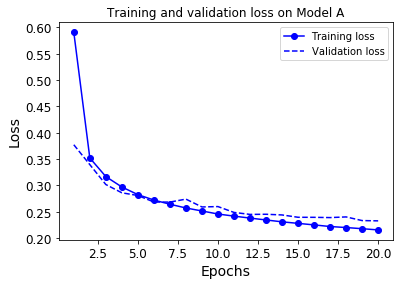

In [41]:
# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on Model A')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
# save model
model_A.save('my_model_A.h5')

In [0]:
keras_backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [85]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-6),
                metrics=["accuracy"])

history_B = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 4ms/sample - loss: -0.5607 - accuracy: 0.0200 - val_loss: 0.6258 - val_accuracy: 0.7120
Epoch 2/20
200/200 [==============================] - 0s 528us/sample - loss: -0.6383 - accuracy: 0.0200 - val_loss: 0.6262 - val_accuracy: 0.7089
Epoch 3/20
200/200 [==============================] - 0s 551us/sample - loss: -0.7207 - accuracy: 0.0200 - val_loss: 0.6265 - val_accuracy: 0.7099
Epoch 4/20
200/200 [==============================] - 0s 535us/sample - loss: -0.7970 - accuracy: 0.0200 - val_loss: 0.6270 - val_accuracy: 0.7099
Epoch 5/20
200/200 [==============================] - 0s 573us/sample - loss: -0.8760 - accuracy: 0.0200 - val_loss: 0.6275 - val_accuracy: 0.7079
Epoch 6/20
200/200 [==============================] - 0s 547us/sample - loss: -0.9525 - accuracy: 0.0250 - val_loss: 0.6281 - val_accuracy: 0.7079
Epoch 7/20
200/200 [==============================] - 0s 546us/sample - lo

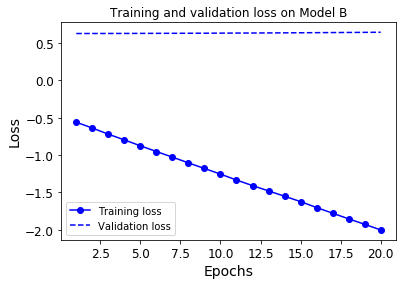

In [86]:
# Plotting the training and validation loss
loss = history_B.history['loss']
val_loss = history_B.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on Model B')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
keras_backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

First, you need to load model A, and create a new model based on the model A’s layers.
Let’s reuse all layers except for the output layer:

In [0]:
model_A = keras.models.load_model('my_model_A.h5')
model_B_on_A = Sequential(model_A.layers[:-1])
model_B_on_A.add(Dense(1, activation='sigmoid'))

Note that model_A and model_B_on_A now share some layers. When you train
model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you must clone model_A’s architecture, then copy its weights (since clone_model() does not clone the weights):

In [0]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Now we could just train model_B_on_A for task B, but since the new output layer was initialized randomly, it will make large errors, at least during the first few epochs, so there will be large error gradients that may wreck the reused weights. 

To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, simply set every layer’s train able attribute to False and compile the model:

In [0]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

Next, we can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [92]:
history_B_on_A = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True

model_B_on_A.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1e-6), metrics=['accuracy'])

history_B_on_A = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 643us/sample - loss: nan - accuracy: 0.0950 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/4
200/200 [==============================] - 0s 529us/sample - loss: nan - accuracy: 0.0950 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/4
200/200 [==============================] - 0s 535us/sample - loss: nan - accuracy: 0.0950 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/4
200/200 [==============================] - 0s 528us/sample - loss: nan - accuracy: 0.0950 - val_loss: nan - val_accuracy: 0.5000
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 4ms/sample - loss: nan - accuracy: 0.0950 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/16
200/200 [==============================] - 0s 546us/sample - loss: nan - accuracy: 0.0950 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/16
200/200 [==============================] - 0s 545us/sample - lo

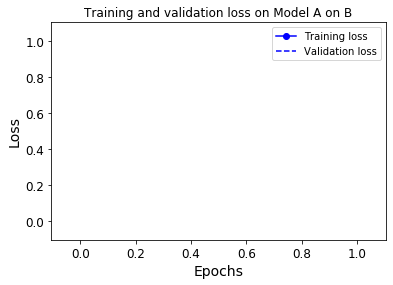

In [93]:
# Plotting the training and validation loss
loss = history_B_on_A.history['loss']
val_loss = history_B_on_A.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on Model A on B')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

So, what’s the final verdict? Well this model’s test accuracy is 99.25%, which means that transfer learning reduced the error rate from 2.8% down to almost 0.7%! That’s a factor of 4!

In [51]:
model_B_on_A.evaluate(X_test_B, y_test_B, verbose=0)

[nan, 0.5]

In [95]:
model_B_on_A.evaluate(X_test_B, y_test_B, verbose=0)

[nan, 0.5]

Are you convinced? Well you shouldn’t be: I cheated! :) I tried many configurations until I found one that demonstrated a strong improvement. If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. What I did is called “torturing the data until it confesses”.

Well it turns out that transfer learning does not work very well
with small dense networks: it works best with deep convolutional neural networks.